<a href="https://colab.research.google.com/github/jo-cho/advances_in_financial_machine_learning/blob/master/bet_sizing_plus_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

META-LABELING AND BET SIZING

This notebook is based on the book *Advances in Financial Machine Learning* by Lopez De Prado. (Chapter 3 and Chapter 10)

# IMPORT LIB

In [0]:
# lib
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

In [0]:
# sklearn

from sklearn.decomposition import PCA
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, BaggingClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_roc_curve
from sklearn.metrics import roc_curve, confusion_matrix, accuracy_score, classification_report
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, validation_curve
from sklearn import metrics

In [0]:
#!pip install -q ta
#import ta

In [0]:
import warnings
warnings.filterwarnings(action='ignore')

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
# Big thanks to mlfinlab!

!pip install mlfinlab
from mlfinlab import data_structures, features, filters, labeling, util, sampling, cross_validation, structural_breaks, microstructural_features
from mlfinlab import bet_sizing as bs

     |████████████████████████████████| 163kB 2.9MB/s 


## Read in data - dollar bars

E-mini S&P Future tick data

In [9]:
# make dollar bars from tick data
threshold = 200_000
raw_dollar_bars = data_structures.get_dollar_bars('/content/drive/My Drive/Colab Notebooks/csv/clean_IVE_tickbidask2.csv', threshold=threshold)
dollar_bars = raw_dollar_bars.set_index(pd.to_datetime(raw_dollar_bars.date_time))
dollar_bars = dollar_bars.drop(columns='date_time')
dollar_bars = dollar_bars.reset_index().drop_duplicates(subset='date_time', keep='last').set_index('date_time')

Reading data in batches:
Batch number: 0
Returning bars 



In [10]:
dollar_bars.head()

,tick_num,open,high,low,close,volume,cum_buy_volume,cum_ticks,cum_dollar_value
date_time,,,,,,,,,
2009-09-28 09:33:08,14,50.79,50.8226,50.7100,50.8200,4136,2598,14,210018.6000
2009-09-28 09:40:44,32,50.81,50.8500,50.7833,50.7833,4008,966,18,203668.6338
2009-09-28 09:44:24,45,50.80,50.9300,50.8000,50.9300,4000,3700,13,203577.0000
2009-09-28 09:46:34,60,51.00,51.0700,51.0000,51.0700,4800,3100,15,245058.0000
2009-09-28 09:46:35,63,51.07,51.0700,51.0700,51.0700,6200,6200,3,316634.0000


In [11]:
len(dollar_bars)

217520

In [0]:
close = dollar_bars.close

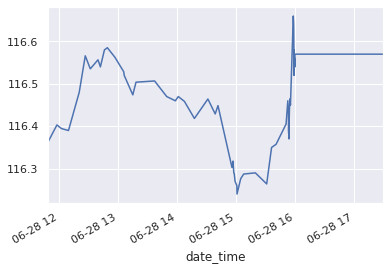

In [13]:
%matplotlib inline
close.iloc[-60:].plot()

Why do we use dollar bars?

In [0]:
from statsmodels.tsa.stattools import adfuller

In [15]:
print('Results of Dickey-Fuller Test:')
dftest = adfuller(close.pct_change().dropna(), autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
for key,value in dftest[4].items():
	dfoutput['Critical Value (%s)'%key] = value
print(dfoutput)

Results of Dickey-Fuller Test:
Test Statistic                    -56.636456
p-value                             0.000000
#Lags Used                         75.000000
Number of Observations Used    217443.000000
Critical Value (1%)                -3.430380
Critical Value (5%)                -2.861553
Critical Value (10%)               -2.566777
dtype: float64


In [0]:
pt_sl = [1,1] # The factor that multiplies 'target' to set the width of the barriers

target = util.get_daily_vol(close,lookback=200) # Dynamic threshold, The unit width of the horizontal barriers
#upper barrier = price *(1+pt*target)
#lower barrier = price *(1-sl*target)

The Cusum Filter

The CUSUM filter is a quality-control method, designed to detect a shift in
the mean value of a measured quantity away from a target value.

In [0]:
h = target.mean()*.5 # threshold level (events took place)
t_events = filters.cusum_filter(close, h) # using symmetric cusum filter, get t_event

In [0]:
vertical_barrier_times = labeling.add_vertical_barrier(t_events, close, num_days=30)
# 청산시간을 한 달로 하자

In [0]:
min_ret = 0.003 # The minimum target return required for running a triple barrier search.

In [20]:
events_0 = labeling.get_events(close,t_events,pt_sl,target,min_ret,3,vertical_barrier_times)
bin_0 = labeling.get_bins(events_0,close)

2020-02-16 10:42:21.167240 100.0% apply_pt_sl_on_t1 done after 0.32 minutes. Remaining 0.0 minutes.


In [0]:
side_0 = bin_0[bin_0.bin != 0].bin

## Primary Model

### Fourth - VPIN & target

In [0]:
vpin = microstructural_features.third_generation.get_vpin(dollar_bars.volume,buy_volume=dollar_bars.cum_buy_volume)

In [0]:
y_side = side_0

vpin = vpin.shift(1)
X_side=pd.DataFrame()
X_side['vpin'] = vpin.loc[y_side.index]

In [0]:
X_side['trgt'] = target.loc[y_side.index]

In [0]:
#X_side['cheat'] = side_0*target # 재미를 위한 치트키

In [0]:
X_side_train, X_side_test, y_side_train, y_side_test = train_test_split(X_side, y_side, test_size=0.4, shuffle=False)

In [0]:
tc = RandomForestClassifier(criterion='entropy',max_depth=20, n_estimators=1000)
tc = tc.fit(X_side_train,y_side_train)

Train Score

In [0]:
y_pred_side_train = tc.predict(X_side_train)

              precision    recall  f1-score   support

          -1       0.98      0.93      0.96      3559
           1       0.94      0.99      0.96      3783

    accuracy                           0.96      7342
   macro avg       0.96      0.96      0.96      7342
weighted avg       0.96      0.96      0.96      7342

Accuracy =  0.9587305911195859

Confusion Matrix


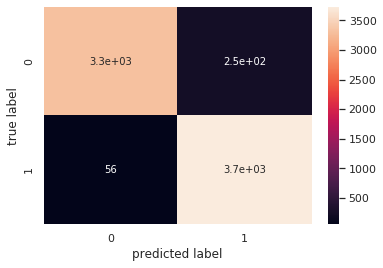

In [29]:
print(classification_report(y_side_train,y_pred_side_train))

print("Accuracy = ", accuracy_score(y_side_train,y_pred_side_train))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_side_train,y_pred_side_train)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

Test Score

In [0]:
y_pred_side = tc.predict(X_side_test)

              precision    recall  f1-score   support

          -1       0.48      0.39      0.43      2382
           1       0.51      0.60      0.55      2513

    accuracy                           0.50      4895
   macro avg       0.50      0.50      0.49      4895
weighted avg       0.50      0.50      0.50      4895

Accuracy =  0.5013278855975485

Confusion Matrix


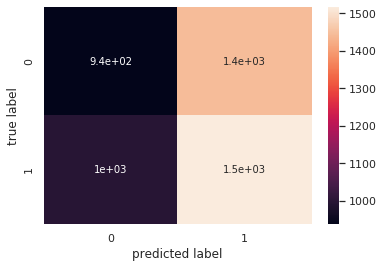

In [31]:
print(classification_report(y_side_test,y_pred_side))

print("Accuracy = ", accuracy_score(y_side_test,y_pred_side))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_side_test,y_pred_side)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

In [0]:
side = pd.Series(y_pred_side_train, index = X_side_train.index)
side2 = pd.Series(y_pred_side, index = X_side_test.index)

In [0]:
tc = tc.fit(X_side,y_side)
side = tc.predict(X_side)

In [0]:
side = pd.Series(side, index = X_side.index)

              precision    recall  f1-score   support

          -1       0.98      0.86      0.91      5941
           1       0.88      0.98      0.93      6296

    accuracy                           0.92     12237
   macro avg       0.93      0.92      0.92     12237
weighted avg       0.93      0.92      0.92     12237

Accuracy =  0.9223665931192285

Confusion Matrix


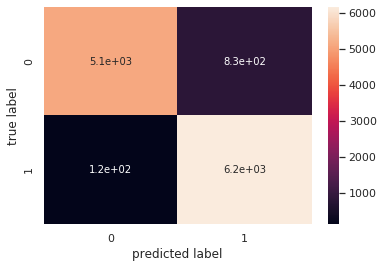

In [35]:
print(classification_report(y_side,side))

print("Accuracy = ", accuracy_score(y_side,side))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_side,side)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

In [36]:
side

2009-09-29 11:02:02    1
2009-09-29 12:44:38    1
2009-09-29 15:31:32   -1
2009-09-30 09:43:21   -1
2009-09-30 09:46:02   -1
                      ..
2019-06-26 09:30:00    1
2019-06-26 14:42:35    1
2019-06-27 09:39:49    1
2019-06-27 13:22:38    1
2019-06-28 09:30:00    1
Length: 12237, dtype: int64

## 2. Generate labels (from a primary model)

Get time stamps of the events using CUSUM filter and point estimate of the volatility.

In [37]:
events = labeling.get_events(close, t_events, pt_sl, target, min_ret, num_threads=3, 
                             vertical_barrier_times = vertical_barrier_times ,side_prediction = side)
bin = labeling.get_bins(events, close)

2020-02-16 10:44:09.507845 100.0% apply_pt_sl_on_t1 done after 0.33 minutes. Remaining 0.0 minutes.


## 3. Features


### Bet Sizing

In [38]:
bars = dollar_bars.iloc[:,1:6]
bars = bars.loc[bin.index,:]
bars.head()

,open,high,low,close,volume
2009-09-29 11:02:02,51.598,51.5980,51.420,51.450,3989
2009-09-29 12:44:38,51.550,51.5896,51.550,51.588,4492
2009-09-29 15:31:32,51.590,51.5900,51.542,51.560,4237
2009-09-30 09:43:21,51.590,51.5900,51.340,51.340,4552
2009-09-30 09:46:02,51.250,51.2500,51.140,51.140,4063


In [0]:
bs_df = bin.join(events.t1.loc[bin.index])

In [40]:
bs_df

,ret,trgt,bin,side,t1
2009-09-29 11:02:02,0.005248,0.004469,1,1.0,2009-09-29 13:01:14
2009-09-29 12:44:38,-0.005777,0.005289,0,1.0,2009-09-30 09:44:58
2009-09-29 15:31:32,0.005264,0.004357,1,-1.0,2009-09-30 09:44:58
2009-09-30 09:43:21,0.007259,0.005012,1,-1.0,2009-09-30 09:51:41
2009-09-30 09:46:02,0.006297,0.005929,1,-1.0,2009-09-30 10:11:18
...,...,...,...,...,...
2019-06-26 09:30:00,0.005800,0.004051,1,1.0,2019-06-28 09:30:00
2019-06-26 14:42:35,0.003471,0.003336,1,1.0,2019-06-27 09:39:49
2019-06-27 09:39:49,0.004756,0.003146,1,1.0,2019-06-28 09:30:00
2019-06-27 13:22:38,0.003384,0.003012,1,1.0,2019-06-28 09:48:20


In [0]:
c = bs.get_concurrent_sides(bs_df.t1,bs_df.side)

In [42]:
c

,t1,side,active_long,active_short
2009-09-29 11:02:02,2009-09-29 13:01:14,1.0,1,0
2009-09-29 12:44:38,2009-09-30 09:44:58,1.0,2,0
2009-09-29 15:31:32,2009-09-30 09:44:58,-1.0,1,1
2009-09-30 09:43:21,2009-09-30 09:51:41,-1.0,1,2
2009-09-30 09:46:02,2009-09-30 10:11:18,-1.0,0,2
...,...,...,...,...
2019-06-26 09:30:00,2019-06-28 09:30:00,1.0,3,0
2019-06-26 14:42:35,2019-06-27 09:39:49,1.0,4,0
2019-06-27 09:39:49,2019-06-28 09:30:00,1.0,4,0
2019-06-27 13:22:38,2019-06-28 09:48:20,1.0,4,0


In [0]:
c_t = c.active_long-c.active_short

In [0]:
X = pd.DataFrame({'c_t':c_t})

### Including side from first model

In [0]:
X['vpin'] = X_side.vpin

In [0]:
X['side'] = side

### X

In [0]:
#X['fd'] = fd

In [51]:
X.head(10)

,c_t,vpin,side
2009-09-29 11:02:02,1,0.282051,1.0
2009-09-29 12:44:38,2,0.583489,1.0
2009-09-29 15:31:32,0,0.105276,-1.0
2009-09-30 09:43:21,-1,0.193963,-1.0
2009-09-30 09:46:02,-2,0.231754,-1.0
2009-09-30 09:51:41,0,0.515137,1.0
2009-09-30 09:57:13,1,0.611273,1.0
2009-09-30 11:25:26,1,0.524173,-1.0
2009-09-30 12:16:48,0,0.017772,-1.0
2009-09-30 12:53:33,-3,0.921569,-1.0


In [0]:
X.dropna(inplace=True)

In [53]:
len(X)

12237

## 4. Fit a second ML model

In [0]:
tmp_data = X.copy()
tmp_data = tmp_data.join(bin.bin)
tmp_data.dropna(inplace=True)

X = tmp_data.iloc[:,:-1]
y = tmp_data[['bin']]

In [0]:
t1 = events['t1'].loc[X.index]
idx = events.loc[X.index].index

In [0]:
#skf = cross_validation.PurgedKFold(n_splits=5,samples_info_sets= t1, pct_embargo = 0.01)

In [0]:
X_train,X_test,y_train, y_test = train_test_split(X, y, test_size=0.4, shuffle=False)

### 1st - Random Forest

In [58]:
avgU = sampling.get_av_uniqueness_from_triple_barrier(t1.to_frame(), bars.close, 3).mean()
max_samples = avgU[0]
max_samples

2020-02-16 10:47:58.282110 100.0% num_concurrent_events done after 0.11 minutes. Remaining 0.0 minutes.
2020-02-16 10:48:03.192893 100.0% _get_average_uniqueness done after 0.07 minutes. Remaining 0.0 minutes.


0.1938089432070224

In [59]:
parameters = { 'n_estimators' : [512, 1000, 2000],
               'max_depth' : [2, 5, 9, 12]}
#hyper-parameter tuning

rf = RandomForestClassifier(criterion='entropy',max_samples=max_samples, class_weight='balanced_subsample')
clf = GridSearchCV(rf, parameters, cv=3, n_jobs=-1)
clf.fit(X_train, y_train.values.ravel())

GridSearchCV(cv=3, error_score=nan,
             estimator=RandomForestClassifier(bootstrap=True, ccp_alpha=0.0,
                                              class_weight='balanced_subsample',
                                              criterion='entropy',
                                              max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              max_samples=0.1938089432070224,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators=100, n_jobs=None,
                                   

In [0]:
clf = clf.best_estimator_

In [0]:
#clf0 = RandomForestClassifier(n_estimators=1,max_depth=18,criterion='entropy',bootstrap = False, class_weight='balanced_subsample')
#clf1 = BaggingClassifier(base_estimator=clf0, max_samples=max_samples, n_estimators=200)
#clf = clf1.fit(X_train, y_train.values.ravel())
#this is the method in the book

#### Train metrics - RF

In [0]:
y_pred_prob_0 = clf.predict_proba(X_train)[:, 1]
y_pred_0 = clf.predict(X_train)

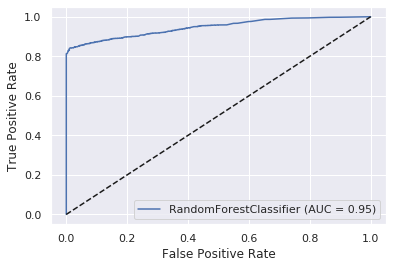

In [63]:
rf_disp = plot_roc_curve(clf, X_train, y_train)
plt.plot([0, 1], [0, 1], 'k--')
plt.show()

              precision    recall  f1-score   support

           0       0.42      0.61      0.50       501
           1       0.97      0.94      0.95      6841

    accuracy                           0.92      7342
   macro avg       0.70      0.78      0.73      7342
weighted avg       0.93      0.92      0.92      7342

Accuracy =  0.9166439662217379

Confusion Matrix


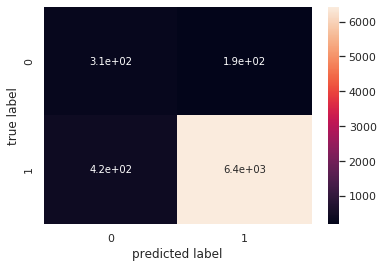

In [64]:
print(classification_report(y_train, y_pred_0))

print("Accuracy = ", accuracy_score(y_train, y_pred_0))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_train, y_pred_0)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

#### Test metrics -RF

In [0]:
y_pred = clf.predict(X_test)
y_pred_prob = clf.predict_proba(X_test)[:, 1]

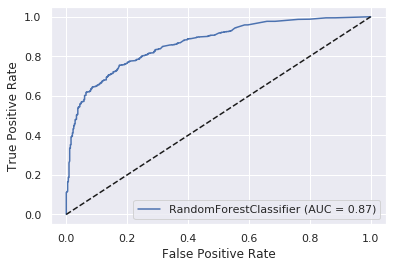

In [66]:
rf_disp = plot_roc_curve(clf, X_test, y_test)
plt.plot([0, 1], [0, 1], 'k--')
plt.show();

              precision    recall  f1-score   support

           0       0.35      0.54      0.43       449
           1       0.95      0.90      0.92      4446

    accuracy                           0.87      4895
   macro avg       0.65      0.72      0.68      4895
weighted avg       0.90      0.87      0.88      4895

Accuracy =  0.8670071501532176

Confusion Matrix


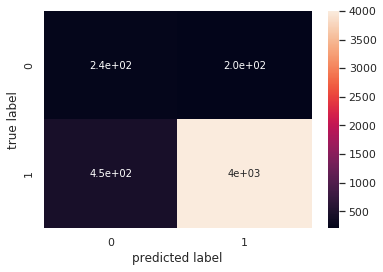

In [67]:
print(classification_report(y_test, y_pred))

print("Accuracy = ", accuracy_score(y_test, y_pred))
print('')
print("Confusion Matrix")
mat = confusion_matrix(y_test, y_pred)
sns.heatmap(mat , annot=True)
plt.xlabel('predicted label')
plt.ylabel('true label');

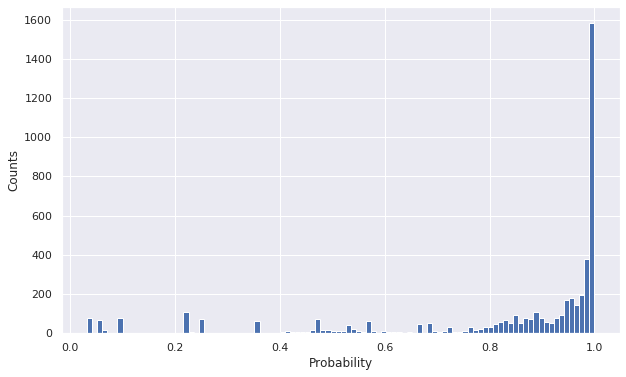

In [68]:
p = pd.Series(y_pred_prob)
f=plt.figure(figsize=(10,6))
a = f.gca()
a.hist(p,bins=100)
plt.xlabel('Probability')
plt.ylabel('Counts')
plt.show()

## Bet Sizing

### 1. Using probabilities from secondary model

When num_classes = 2,



$$ z=\frac{p[x=1]−\frac{1}{2}}{\sqrt{p[x=1](1−p[x=1])}} $$

$$ m=x(2Z[z]−1) $$

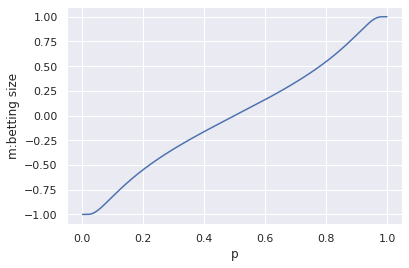

In [69]:
import scipy.stats as ss
p = np.linspace(0.001,1,1000,endpoint=False)
z = (p-0.5)/(np.sqrt(p*(1-p)))
Z_z = ss.norm.cdf(z)
m = (2 * Z_z -1) # np.sign(x)=1 always? increasing function
plt.plot(p,m)
plt.xlabel('p');
plt.ylabel('m:betting size');

In [0]:
p_rf = y_pred_prob # from RF (secondary model)

In [71]:
new_data = y_test.copy()
new_data['bin_pred_rf'] = y_pred
new_data['p'] = p_rf
new_data

,bin,bin_pred_rf,p
2015-06-29 09:49:56,0,0,0.478595
2015-06-29 10:30:17,1,1,0.998936
2015-06-29 11:14:39,1,1,0.999749
2015-06-29 13:05:23,0,0,0.495307
2015-06-29 14:23:46,1,1,0.884206
...,...,...,...
2019-06-26 09:30:00,1,1,0.942083
2019-06-26 14:42:35,1,1,0.929617
2019-06-27 09:39:49,1,0,0.355177
2019-06-27 13:22:38,1,1,0.926472


In [0]:
new_events = events.loc[new_data.index]
bs_df = pd.concat([new_events, new_data],axis=1)

In [73]:
bs_df.head()

,t1,trgt,side,pt,sl,bin,bin_pred_rf,p
2015-06-29 09:49:56,2015-06-29 11:14:39,0.004481,1.0,1,1,0,0,0.478595
2015-06-29 10:30:17,2015-06-29 13:06:06,0.004435,-1.0,1,1,1,1,0.998936
2015-06-29 11:14:39,2015-06-29 14:15:00,0.004559,-1.0,1,1,1,1,0.999749
2015-06-29 13:05:23,2015-06-29 15:46:45,0.005263,1.0,1,1,0,0,0.495307
2015-06-29 14:23:46,2015-06-30 09:30:00,0.005722,1.0,1,1,1,1,0.884206


In [74]:
m_prob_rf = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p, num_classes=2, num_threads=3, pred=bs_df.side)
m_prob_rf

2015-06-29 09:49:56   -0.034179
2015-06-29 10:30:17   -1.000000
2015-06-29 11:14:39   -1.000000
2015-06-29 13:05:23   -0.007489
2015-06-29 14:23:46    0.770144
                         ...   
2019-06-26 09:30:00    0.941588
2019-06-26 14:42:35    0.906957
2019-06-27 09:39:49   -0.237820
2019-06-27 13:22:38    0.897738
2019-06-28 09:30:00    0.689705
Name: signal, Length: 4895, dtype: float64

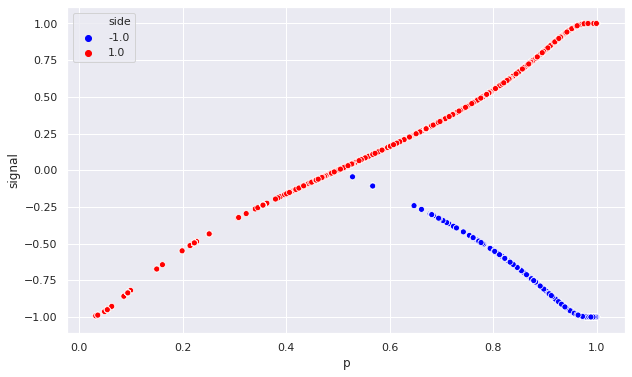

In [180]:
plt.figure(figsize=(10,6))
sns.scatterplot(x= bs_df.p, hue=bs_df.side, palette=['blue','red'],y=m_prob_rf)

#### Average Bet Sizing

Every bet is associated with a holding period, spanning from the time it originated to
the time the first barrier is touched, t1. One possible approach is to
override an old bet as a new bet arrives; however, that is likely to lead to excessive
turnover. A more sensible approach is to average all sizes across all bets still active at a
given point in time.

In [76]:
m_prob_avg_rf = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p, num_classes=2, num_threads=3, average_active=True, pred=bs_df.side)
m_prob_avg_rf = m_prob_avg_rf.loc[bs_df.index]
m_prob_avg_rf

2020-02-16 10:53:03.137810 100.0% mp_avg_active_signals done after 0.26 minutes. Remaining 0.0 minutes.


2015-06-29 09:49:56   -0.034179
2015-06-29 10:30:17   -0.517090
2015-06-29 11:14:39   -1.000000
2015-06-29 13:05:23   -0.669163
2015-06-29 14:23:46    0.381327
                         ...   
2019-06-26 09:30:00    0.663647
2019-06-26 14:42:35    0.724475
2019-06-27 09:39:49    0.438281
2019-06-27 13:22:38    0.549226
2019-06-28 09:30:00    0.793722
Length: 4895, dtype: float64

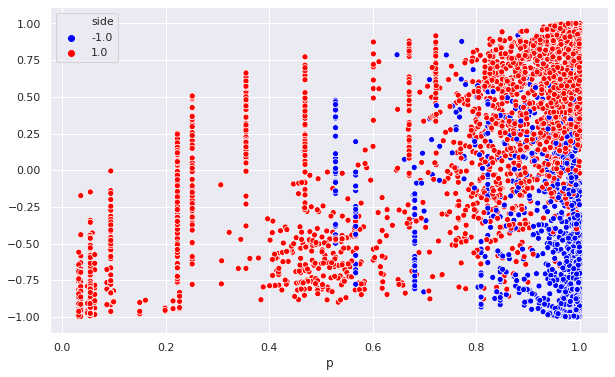

In [183]:
plt.figure(figsize=(10,6))
sns.scatterplot(x= bs_df.p, hue=bs_df.side, palette=['blue','red'],y=m_prob_avg_rf)

#### Discrete Average Bet Sizing

Averaging reduces some of the excess turnover, but still it is likely that small trades
will be triggered with every prediction. As this jitter would cause unnecessary overtrading, I suggest you discretize the bet size as $m^∗=\text{round}[\frac{m}{d}]d$, where $d ∈
(0, 1]$ determines the degree of discretization.

In [78]:
m_prob_discrete_rf = bs.bet_size_probability(events = bs_df[['t1']], prob = bs_df.p, num_classes=2,pred=bs_df.side, num_threads=3, average_active=True, step_size=0.1)
m_prob_discrete_rf = m_prob_discrete_rf.loc[bs_df.index]
m_prob_discrete_rf

2020-02-16 10:53:40.528725 100.0% mp_avg_active_signals done after 0.24 minutes. Remaining 0.0 minutes.


2015-06-29 09:49:56   -0.0
2015-06-29 10:30:17   -0.5
2015-06-29 11:14:39   -1.0
2015-06-29 13:05:23   -0.7
2015-06-29 14:23:46    0.4
                      ... 
2019-06-26 09:30:00    0.7
2019-06-26 14:42:35    0.7
2019-06-27 09:39:49    0.4
2019-06-27 13:22:38    0.5
2019-06-28 09:30:00    0.8
Length: 4895, dtype: float64

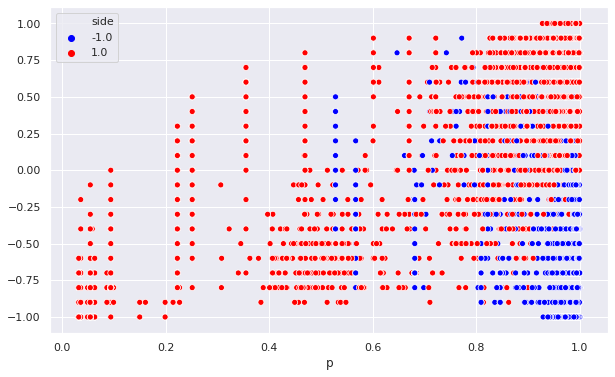

In [184]:
plt.figure(figsize=(10,6))
sns.scatterplot(x= bs_df.p, hue=bs_df.side, palette=['blue','red'],y=m_prob_discrete_rf)

plot

In [0]:
bet_sizes_rf = pd.DataFrame({'m_rf':m_prob_rf,'m_avg_rf':m_prob_avg_rf,'m_dis_rf':m_prob_discrete_rf})
#bet_sizes_gbc = pd.DataFrame({'m_gb':m_prob_gbc,'m_avg_gb':m_prob_avg_gbc,'m_dis_gb':m_prob_discrete_gbc})

Text(0.5, 1.0, 'Bet Size 100 points')

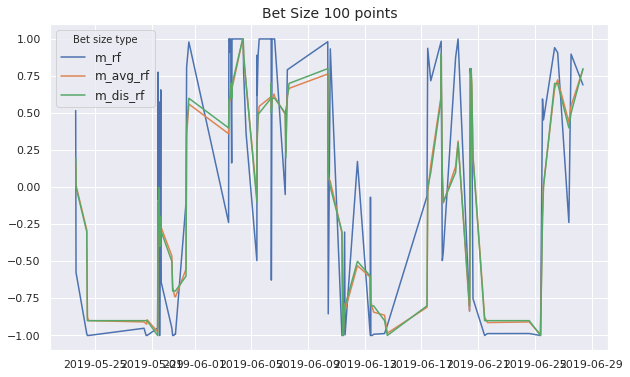

In [81]:
fig, ax = plt.subplots(figsize=(10,6))
ax.plot(bet_sizes_rf[-100:])
ax.legend(labels=bet_sizes_rf.columns,loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_title("Bet Size 100 points", fontsize=14)

Text(0.5, 1.0, 'Bet Size Distribution RF')

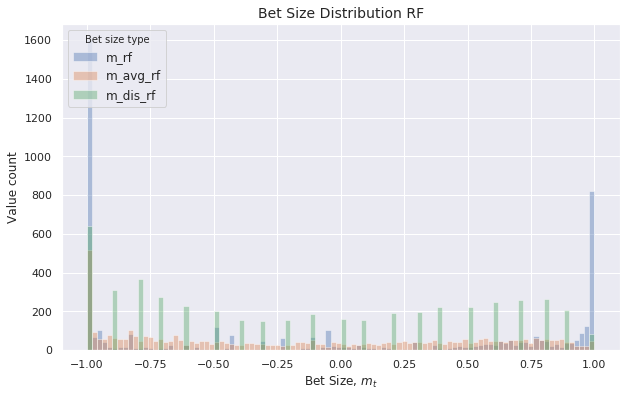

In [82]:
fig, ax = plt.subplots(figsize=(10,6))
for c in ['m_rf','m_avg_rf','m_dis_rf']:
    ax.hist(bet_sizes_rf[c],  label=c, alpha=0.4, bins=100)
ax.legend(loc='upper left', fontsize=12, title="Bet size type", title_fontsize=10)
ax.set_xlabel("Bet Size, $m_t$", fontsize=12)
ax.set_ylabel("Value count", fontsize=12)
ax.set_title("Bet Size Distribution RF", fontsize=14)

### Reserving cash

- We reserve cash for the possibility that the trading signal strengthens before it weakens.

$c_t = c_{t,l} - c_{t,s} $ 

where $c_{t,l}$ is the number of concurrent long bets at
time $t$, and $c_{t,s}$ is the number of concurrent short bets at time $t$

$$m_t = \begin{cases}
  \frac{F[c_t]-F[0]}{1-F[0]} & \text{if}\ c_t \ge 0 \\
  \frac{F[c_t]-F[0]}{F[0]} & \text{if}\ c_t < 0
\end{cases}$$

where $F[x]$ is CDF of the fitted mixture of two Gaussians for a value x.

EF3M Algorithm

https://github.com/hudson-and-thames/research/blob/master/Chapter10/ef3m_testing.ipynb

In [85]:
m_reserve = bs.bet_sizing.bet_size_reserve(events_t1=bs_df['t1'], sides=bs_df.side, return_parameters=True, fit_runs=25)
m_reserve[0]

|#########################| Completed 25 of 25 fitting rounds.

,t1,side,active_long,active_short,c_t,bet_size
2015-06-29 09:49:56,2015-06-29 11:14:39,1.0,1,0,1,0.072915
2015-06-29 10:30:17,2015-06-29 13:06:06,-1.0,1,1,0,0.000000
2015-06-29 11:14:39,2015-06-29 14:15:00,-1.0,0,2,-2,-0.084744
2015-06-29 13:05:23,2015-06-29 15:46:45,1.0,1,2,-1,-0.038734
2015-06-29 14:23:46,2015-06-30 09:30:00,1.0,2,0,2,0.147719
...,...,...,...,...,...,...
2019-06-26 09:30:00,2019-06-28 09:30:00,1.0,3,0,3,0.226848
2019-06-26 14:42:35,2019-06-27 09:39:49,1.0,4,0,4,0.310123
2019-06-27 09:39:49,2019-06-28 09:30:00,1.0,4,0,4,0.310123
2019-06-27 13:22:38,2019-06-28 09:48:20,1.0,4,0,4,0.310123


In [86]:
print('Parameters are ',m_reserve[1])

Parameters are  {'mu_1': -6.75631, 'mu_2': 5.03627, 'sigma_1': 2.90565, 'sigma_2': 5.57091, 'p_1': 0.5983}


In [0]:
from scipy.stats import norm, moment

Calculate the first 5 centered and raw moments from the c_t distribution.

In [146]:
central_mmnts = [moment(c_t.to_numpy(), moment=i) for i in range(1, 6)]
central_mmnts

[0.0,
 117.35521611821355,
 -4670.853232371247,
 402516.7005925298,
 -30409339.8632583]

In [148]:
raw_mmnts = bs.raw_moment(central_moments=central_mmnts, dist_mean=c_t.mean())
raw_mmnts

[0.13081141222284035,
 117.37232774378128,
 -4624.796789318921,
 400084.74608598894,
 -30146867.60502265]

Fit the mixture of distributions.

In [153]:
m2n = bs.M2N(raw_mmnts, epsilon=1e-5, factor=5, n_runs=20,
              variant=2, max_iter=10_000, num_workers=1)

df_fit_results = m2n.mp_fit()

|#########################| Completed 20 of 20 fitting rounds.

In [185]:
df_fit_results.head(3)

,mu_1,mu_2,sigma_1,sigma_2,p_1,error
0,-37.289945,8.347814,29.759265,6.675092,0.031626,7.666931e+06
0,-28.439965,7.975674,31.877088,6.123195,0.044051,1.729382e+07
0,-26.503583,5.067319,32.893580,5.980563,0.044545,8.070758e+07


In [157]:
fit_params = bs.most_likely_parameters(df_fit_results)
fit_params

{'mu_1': -30.08906,
 'mu_2': 7.85586,
 'p_1': 0.04097,
 'sigma_1': 31.655,
 'sigma_2': 6.2617}

In [0]:
params_list = [fit_params[key] for key in ['mu_1', 'mu_2', 'sigma_1', 'sigma_2', 'p_1']]

In [0]:
def pdf_mixture(x_val ,parameters):
    mu_1, mu_2, sigma_1, sigma_2, p_1 = parameters  # Parameters reassigned for clarity.
    return p_1 * norm.pdf(x_val, mu_1, sigma_1) + (1-p_1) * norm.pdf(x_val, mu_2, sigma_2)

Text(0, 0.5, 'PDF mixture')

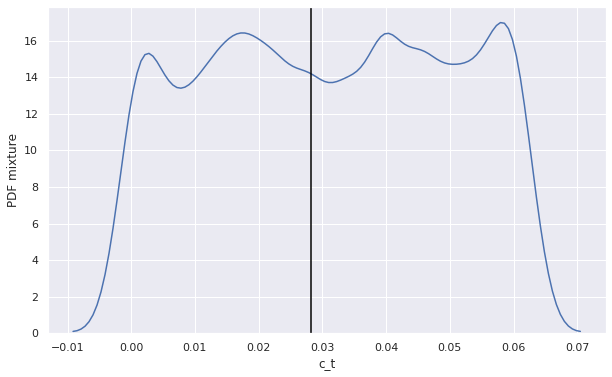

In [217]:
plt.figure(figsize=(10,6))
sns.kdeplot(pdf_mixture(c_t, params_list))
plt.axvline(pdf_mixture(0,params_list), c='black')
plt.xlabel('c_t')
plt.ylabel('PDF mixture')

Text(0, 0.5, 'CDF mixture')

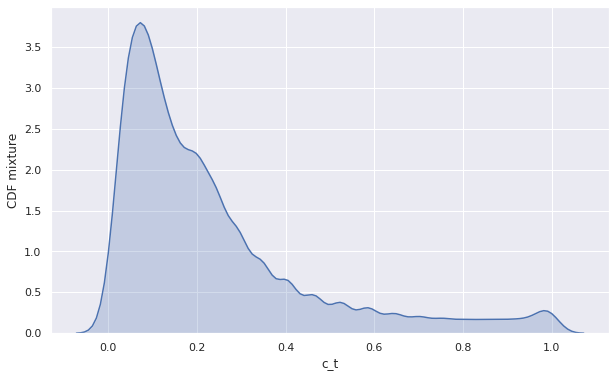

In [215]:
plt.figure(figsize=(10,6))
sns.kdeplot(bs.cdf_mixture(c_t, params_list), shade=True)
plt.xlabel('c_t')
plt.ylabel('CDF mixture')

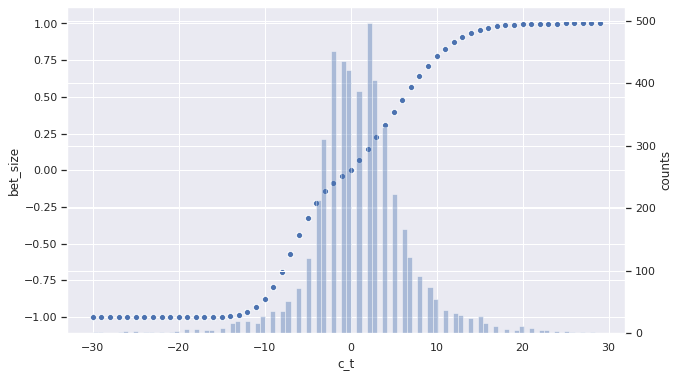

In [214]:
plt.figure(figsize=(10,6))
ax = sns.scatterplot(m_reserve[0].c_t,m_reserve[0].bet_size)
ax2 = ax.twinx()
plt.hist(m_reserve[0].c_t, bins=100, alpha=0.4)
plt.ylabel('counts')
plt.show()

### Budgeting Approach

- The goal is that the
maximum position is not reached before the last concurrent signal is triggered.

$$ m_t = c_{t,l} \frac{1}{max_i[c_{i,l}]}-c_{t,s} \frac{1}{max_i[c_{i,s}]} $$

In [221]:
m_budget = bs.bet_sizing.bet_size_budget(bs_df.t1, bs_df.side)
m_budget

,t1,side,active_long,active_short,bet_size
2015-06-29 09:49:56,2015-06-29 11:14:39,1.0,1,0,0.034483
2015-06-29 10:30:17,2015-06-29 13:06:06,-1.0,1,1,0.004180
2015-06-29 11:14:39,2015-06-29 14:15:00,-1.0,0,2,-0.060606
2015-06-29 13:05:23,2015-06-29 15:46:45,1.0,1,2,-0.026123
2015-06-29 14:23:46,2015-06-30 09:30:00,1.0,2,0,0.068966
...,...,...,...,...,...
2019-06-26 09:30:00,2019-06-28 09:30:00,1.0,3,0,0.103448
2019-06-26 14:42:35,2019-06-27 09:39:49,1.0,4,0,0.137931
2019-06-27 09:39:49,2019-06-28 09:30:00,1.0,4,0,0.137931
2019-06-27 13:22:38,2019-06-28 09:48:20,1.0,4,0,0.137931


In [222]:
bet_sizes_others = pd.DataFrame({'mreserve':m_reserve[0].bet_size,'mbudget':m_budget.bet_size})
bet_sizes_others.head()

,mreserve,mbudget
2015-06-29 09:49:56,0.072915,0.034483
2015-06-29 10:30:17,0.000000,0.004180
2015-06-29 11:14:39,-0.084744,-0.060606
2015-06-29 13:05:23,-0.038734,-0.026123
2015-06-29 14:23:46,0.147719,0.068966


In [0]:
bet_sizes = pd.concat([bet_sizes_rf, bet_sizes_others], axis=1)
data_size = bet_sizes.copy()
data_size['NoSizeRF'] = (bs_df.side * bs_df.bin_pred_rf).loc[bet_sizes.index]
#daa_size['NoSizeGB'] = (bs_df.side * bs_df.bin_pred_gbc).loc[bet_sizes.index]
data_size['side'] = (bs_df.side).loc[bet_sizes.index]
data_size['ret'] = bin.ret.loc[bet_sizes.index]


In [224]:
data_size

,m_rf,m_avg_rf,m_dis_rf,mreserve,mbudget,NoSizeRF,side,ret
2015-06-29 09:49:56,-0.034179,-0.034179,-0.0,0.072915,0.034483,0.0,1.0,-0.004975
2015-06-29 10:30:17,-1.000000,-0.517090,-0.5,0.000000,0.004180,-1.0,-1.0,0.004644
2015-06-29 11:14:39,-1.000000,-1.000000,-1.0,-0.084744,-0.060606,-1.0,-1.0,0.004604
2015-06-29 13:05:23,-0.007489,-0.669163,-0.7,-0.038734,-0.026123,0.0,1.0,-0.005724
2015-06-29 14:23:46,0.770144,0.381327,0.4,0.147719,0.068966,1.0,1.0,0.006820
...,...,...,...,...,...,...,...,...
2019-06-26 09:30:00,0.941588,0.663647,0.7,0.226848,0.103448,1.0,1.0,0.005800
2019-06-26 14:42:35,0.906957,0.724475,0.7,0.310123,0.137931,1.0,1.0,0.003471
2019-06-27 09:39:49,-0.237820,0.438281,0.4,0.310123,0.137931,0.0,1.0,0.004756
2019-06-27 13:22:38,0.897738,0.549226,0.5,0.310123,0.137931,1.0,1.0,0.003384


# Further studies

### Returns

In [225]:
data_size.columns

Index(['m_rf', 'm_avg_rf', 'm_dis_rf', 'mreserve', 'mbudget', 'NoSizeRF',
       'side', 'ret'],
      dtype='object')

In [0]:
bet_ret = pd.DataFrame()
bet_ret['ProbRF'] = data_size.m_rf * data_size.ret
bet_ret['ProbAvgRF'] = data_size.m_avg_rf * data_size.ret
bet_ret['ProbDiscreteRF'] = data_size.m_dis_rf * data_size.ret
bet_ret['NoSizeRF'] = data_size.NoSizeRF * data_size.ret
bet_ret['SidesOnly'] = 1 * data_size.ret
bet_ret['Reserve'] = data_size.mreserve * data_size.ret
bet_ret['Budget'] = data_size.mbudget * data_size.ret

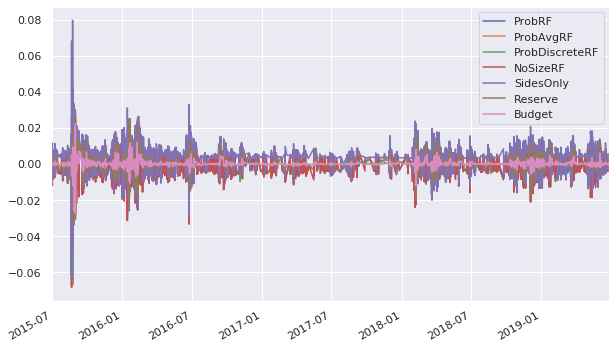

In [227]:
bet_ret.plot(figsize=(10,6))

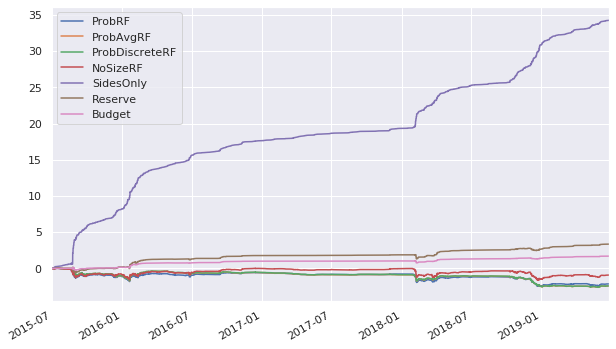

In [228]:
bet_ret.cumsum().plot(figsize=(10,6))

Text(0.5, 1.0, 'Meta-Labeling vs. Primary Model Only (return)')

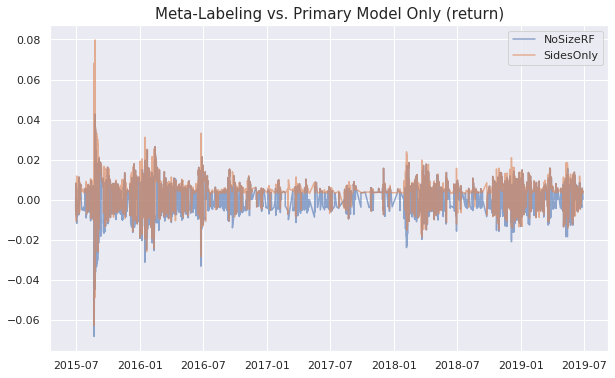

In [229]:
plt.figure(figsize=(10,6))
plt.plot(bet_ret[['NoSizeRF','SidesOnly']], alpha=0.6)
plt.legend(['NoSizeRF','SidesOnly'])
plt.title('Meta-Labeling vs. Primary Model Only (return)', fontsize=15)

Text(0.5, 1.0, 'Meta-Labeling vs. Primary Model Only')

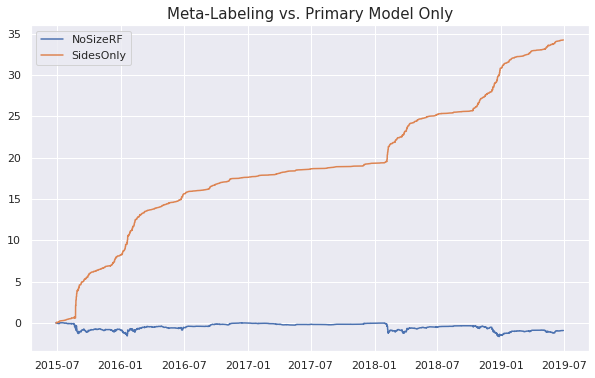

In [230]:
plt.figure(figsize=(10,6))
plt.plot(bet_ret[['NoSizeRF','SidesOnly']].cumsum())
plt.legend(['NoSizeRF','SidesOnly'])
plt.title('Meta-Labeling vs. Primary Model Only', fontsize=15)

Text(0.5, 1.0, 'Bet-Sizing vs. BinaryBet')

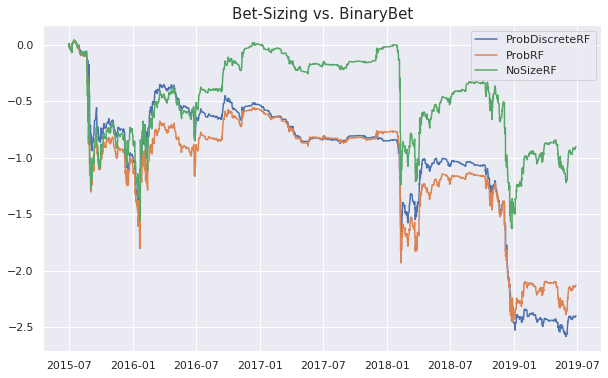

In [231]:
plt.figure(figsize=(10,6))
plt.plot(bet_ret[['ProbDiscreteRF','ProbRF','NoSizeRF']].cumsum())
plt.legend(['ProbDiscreteRF','ProbRF','NoSizeRF'])
plt.title('Bet-Sizing vs. BinaryBet', fontsize=15)

Text(0.5, 1.0, 'Bet-Sizing Types')

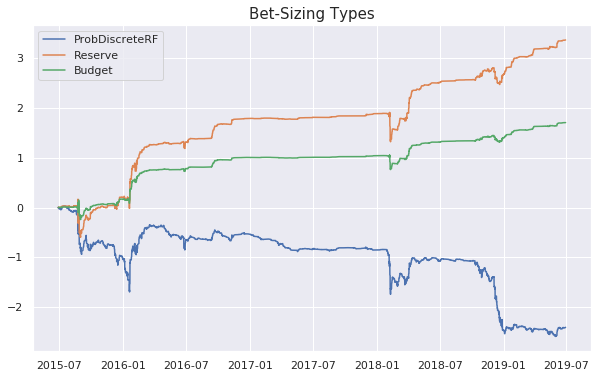

In [232]:
plt.figure(figsize=(10,6))
plt.plot(bet_ret[['ProbDiscreteRF','Reserve','Budget']].cumsum())
plt.legend(['ProbDiscreteRF','Reserve','Budget'])
plt.title('Bet-Sizing Types', fontsize=15)

### Sharpe Ratio

In [0]:
def get_daily_returns(intraday_returns):
    """
    This changes returns into daily returns that will work using pyfolio. Its not perfect...
    """
    
    cum_rets = ((intraday_returns + 1).cumprod())

    # Downsample to daily
    daily_rets = cum_rets.resample('B').last()

    # Forward fill, Percent Change, Drop NaN
    daily_rets = daily_rets.ffill().pct_change().dropna()
    
    return daily_rets

In [0]:
def sr(df):
    out = pd.DataFrame(index=['Ann Sharpe Ratio'])
    for c in df.columns:
        out[c] = (df[c].mean()/df[c].std()*(252**.5))
    return out

In [0]:
daily_ret = get_daily_returns(bet_ret)

In [236]:
daily_ret

,ProbRF,ProbAvgRF,ProbDiscreteRF,NoSizeRF,SidesOnly,Reserve,Budget
2015-06-30,-0.003797,-0.020110,-0.020517,0.006585,0.053413,0.005916,0.002469
2015-07-01,-0.013258,-0.004879,-0.003617,-0.023480,-0.003685,-0.001629,-0.000732
2015-07-02,-0.017384,-0.007835,-0.007750,-0.029359,0.023934,-0.001283,-0.000643
2015-07-03,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
2015-07-06,-0.019337,-0.018259,-0.017969,-0.019525,0.019106,-0.001698,-0.001015
...,...,...,...,...,...,...,...
2019-06-24,-0.003581,-0.003297,-0.003266,-0.003629,0.003629,-0.000141,-0.000095
2019-06-25,0.000773,-0.004649,-0.004734,0.004934,0.012680,-0.000012,-0.000048
2019-06-26,0.008626,0.006373,0.006499,0.009291,0.009291,0.002394,0.001079
2019-06-27,0.001904,0.003947,0.003598,0.003384,0.008157,0.002526,0.001123


In [237]:
sr(daily_ret)

,ProbRF,ProbAvgRF,ProbDiscreteRF,NoSizeRF,SidesOnly,Reserve,Budget
Ann Sharpe Ratio,-0.398833,-0.718549,-0.708862,0.057521,4.605741,1.734386,1.590073


The Sharpe ratio associated with a binary outcome can be derived as

$$ \theta[p,n,\pi_-,\pi_+] = \frac{(\pi_+-\pi_-)p+\pi_-}{(\pi_+-\pi_-)\sqrt{p(1-p)}}\sqrt{n}
$$

where {𝜋−,𝜋+} determine the payoff from negative and positive outcomes, 𝑝 is the probability of a positive outcome, and 𝑛 is the number of outcomes per year

## Applying Deep learning or Reinforcement learning

get probabilities from Q-value - Softmax

# REFERENCE

Marcos Lopez de Prado. Advances in Financial Machine Learning. Wiley, 2018

https://github.com/hudson-and-thames/research

Marcos Lopez de Prado and Matthew D. Foreman. “A mixture of Gaussians approach to mathematical portfolio oversight: the EF3M algorithm”. In: Quantitative Finance14.5 (2014), pp. 913–930.

Yakup Kara
, Melek Acar Boyacioglu 
, Ömer Kaan Baykan. "Predicting direction of stock price index movement using artificial neural
networks and support vector machines: The sample of the Istanbul Stock Exchange"


https://scikit-learn.org/stable/modules/svm.html#scores-and-probabilities

s/o to mlfinlab, ta, pyfolio